In [1]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import warnings
from tqdm.notebook import tqdm

In [2]:
def initial_E(x, A, a):
    """
    Начальное распределение - гауссов пучок с амплитудой A
    А^2 характеризует мощность пучка
    """
    
    return A * np.exp(-x**2/(2*a**2))


def computeE(A, a, LAMBDA, E2, N, L, Z, dZ, i_max=400, eps=1e-4):
    """
    Вычисление слоёв электрического поля Е
    """   
    
    h = 2*L/N
    K = 2*np.pi/LAMBDA
    x = np.arange(-L, L, h)
    E = np.zeros((Z,N), dtype=np.complex128)
    
    
    def checkApproximation(E, Eup):
        """
        Вычисляет, на сколько нижний(E) и верхний(Eup) слои удовлетворяют нелинейному уравнению по схеме Кранка-Николсона
        """

        E_mean = (Eup+E)/2
        tmp = 2j*K*(Eup[1:-1]-E[1:-1])/dZ+(E_mean[2:]-2*E_mean[1:-1]+E_mean[:-2])/h**2+K**2*E2*np.abs(E_mean[1:-1])**2*E_mean[1:-1]
        return np.sum(np.abs(tmp))
    
    
    E[0] = initial_E(x, A=A, a=a)
    E[0, 0] = 0
    E[0, -1] = 0
    
    for z in tqdm(range(Z-1)):
        E[z+1] = E[z]    # Следующий слой не сильно отличается от предыдущего, поэтому используем такое приближение 
        i_iter = 0    # Следим за количеством итераций 
        while i_iter < i_max and checkApproximation(E[z], E[z+1]) > eps:            
            mshape = (N-2, N)
            sparse_matrix = sparse.dia_matrix(mshape, dtype=np.complex128)
            sparse_matrix += sparse.diags(2j*K/dZ*np.ones(mshape[0]), 1, shape = mshape)
            sparse_matrix += sparse.diags(np.ones(mshape[0])/h**2/2, 2, shape = mshape)
            sparse_matrix += sparse.diags(-np.ones(mshape[0])/h**2, 1, shape = mshape)
            sparse_matrix += sparse.diags(np.ones(mshape[0])/h**2/2, 0, shape = mshape)
            sparse_matrix += sparse.diags(K**2*E2*(np.abs(E[z, 1:]+E[z+1, 1:])**2)/4/2, 1, shape = mshape)

            # 2 граничных условия
            mshape = (N, N)
            sparse_matrix.resize(mshape)
            sparse_matrix += sparse.diags([1, 0], -N+2, shape = mshape)
            sparse_matrix += sparse.diags([0]*(N-1) + [1], 0, shape = mshape)

            b = np.zeros(N, dtype = np.complex128)
            b[:-2] += 2j*K/dZ * E[z, 1:-1]
            b[:-2] += -np.ones(N-2)/h**2/2 * E[z, 2:]
            b[:-2] += np.ones(N-2)/h**2 * E[z, 1:-1]
            b[:-2] += -np.ones(N-2)/h**2/2 * E[z, :-2]
            b[:-2] += -K**2*E2*(np.abs(E[z, 1:-1]+E[z+1, 1:-1])**2)/4/2*E[z, 1:-1]

            next_layer = spsolve(sparse_matrix, b)

            E[z+1] = next_layer
            E[z+1, 0] = 0
            E[z+1, -1] = 0

            i_iter += 1

        if i_iter >= i_max:
            warnings.warn("The iteration method does not converge for n_iter={}, A={}, z={}".format(i_max, A, z))

    return E, x


def plotEnergy(I):
    energy = np.sum(I, axis=1)

    fig, ax = plt.subplots(figsize = (7, 5))
    ax.set_ylim(0.9*min(energy), 1.1*max(energy))
    ax.set_xlabel("Слой Z")
    ax.set_ylabel("Интеграл энергии")
    ax.plot(energy, color = 'green')
    plt.title("$\sum_{i=0}^{N} E_i$")
    plt.show()
    


def plotI(I, x, interval=20):
    """
    Выводит анимацию для I = E^2
    """
    
    fig, ax = plt.subplots(figsize = (8, 6))
    ln, = plt.plot([], [], color = 'b', linestyle = '--', label = 'initial')
    ln1, = plt.plot([], [], color = 'r', linestyle = '-', label = 'current')

    def init():
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(0, 1.1*np.max(I))
        ln.set_data(x, I[0])
        ax.set_ylabel("E")
        ax.set_title("A = {}".format(np.sqrt(max(I[0]))))
        return ln,

    def update(i):
        ax.set_xlabel("x")
        ln1.set_data(x, I[i])
        ln1.set_label("номер слоя Z = {}".format(i))
        ax.legend()
        return ln,

    anim = FuncAnimation(fig, update, frames=tqdm(range(len(I))), init_func=init, interval=20, blit=True)
    return anim.to_html5_video()

Рассмотрим следующие начальные параметры:
$$ a = 1, \lambda = 10^{-3}, \varepsilon_2 = 10^{-6} $$
Соотношение 
$$ |A|^2 \sim \frac{\lambda^2}{\varepsilon_2 a^2} $$
даёт оценку на $A_\text{порог} \sim 1$

Экспериментально получаем эффект самофокусировки при $A \ge 0.25$

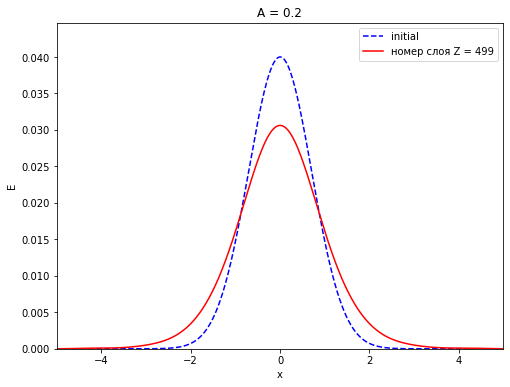

In [3]:
# При A = 0.2 эффекта нет

E, x = computeE(A=0.2, a=1, LAMBDA=1e-3, E2=1e-6, N=1000, L=5, Z=500, dZ=20, i_max=400, eps=1e-6)
I = np.abs(E)**2

anim = plotI(I, x)
HTML(anim)

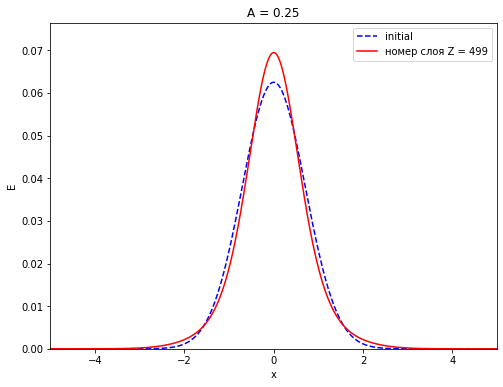

In [4]:
# При А = 0.25 эффект уже есть 

E, x = computeE(A=0.25, a=1, LAMBDA=1e-3, E2=1e-6, N=1000, L=5, Z=500, dZ=10, i_max=400, eps=1e-6)
I = np.abs(E)**2

anim = plotI(I, x)
HTML(anim)

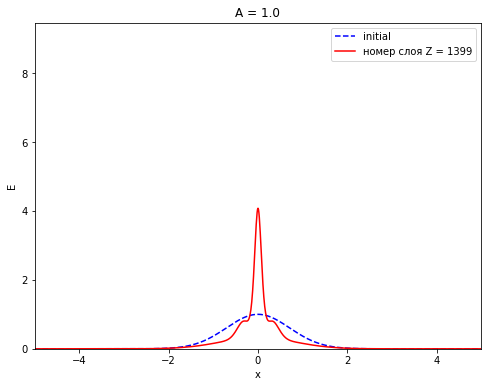

In [5]:
# При А = 1 эффект тоже есть

E, x = computeE(A=1, a=1, LAMBDA=1e-3, E2=1e-6, N=1000, L=5, Z=1400, dZ=1, i_max=400, eps=1e-6)
I = np.abs(E)**2

anim = plotI(I, x)
HTML(anim)

Вид сверху:

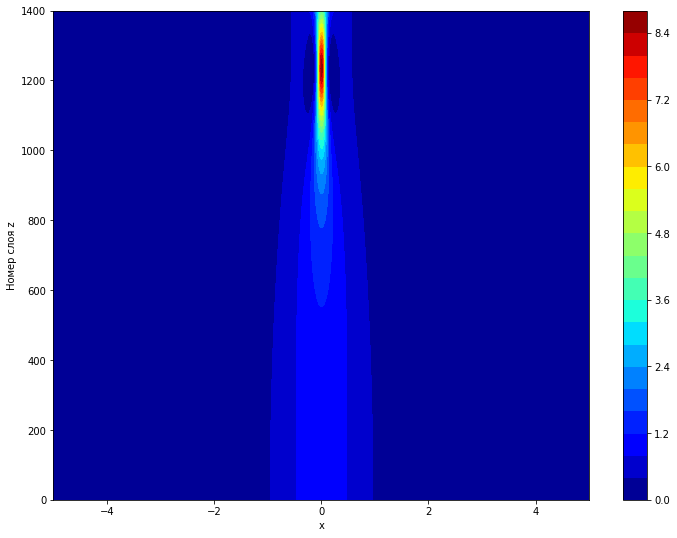

In [6]:
fig, ax = plt.subplots(figsize = (12,9))
ax.set_xlabel("x")
ax.set_ylabel("Номер слоя z")
colorinterpolation = 25
colourMap = plt.cm.jet
picture = ax.contourf(I, colorinterpolation, cmap=colourMap, extent=(-5, 5, 0, 1400))
fig.colorbar(picture)

Проверим, сохраняется ли энергия:


A = 0.2


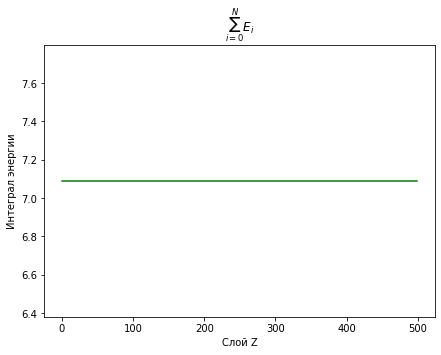


A = 1


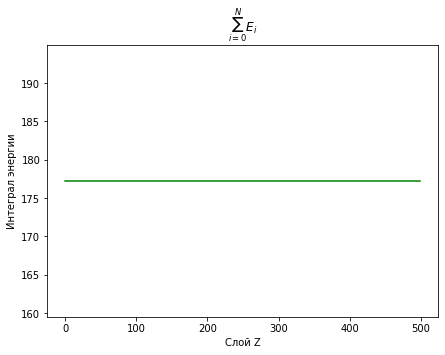

In [7]:
for A in [0.2, 1]:
    E, x = computeE(A=A, a=1, LAMBDA=1e-3, E2=1e-6, N=1000, L=5, Z=500, dZ=3)
    I = np.abs(E)**2
    
    print("A = {}".format(A))
    plotEnergy(I)

Изменим один из параметров

Пусть $\varepsilon_2 = 2.5 \cdot 10^{-7}$

Из оценки $|A|^2 \sim \frac{\lambda^2}{\varepsilon_2 a^2}$ следует, что $A_\text{порог}$ должен быть больше в два раза

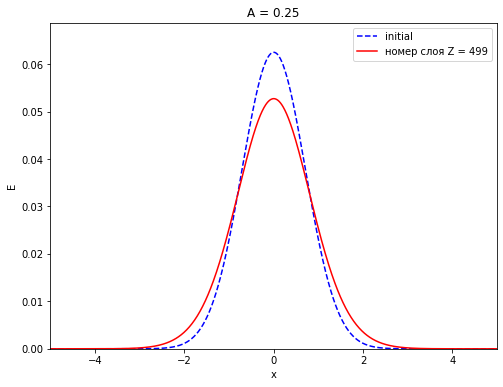

In [8]:
# И правда, при А = 0.25 самофокусировки уже нет 

E, x = computeE(A=0.25, a=1, LAMBDA=1e-3, E2=2.5e-7, N=1000, L=5, Z=500, dZ=10, i_max=400, eps=1e-6)
I = np.abs(E)**2

anim = plotI(I, x)
HTML(anim)

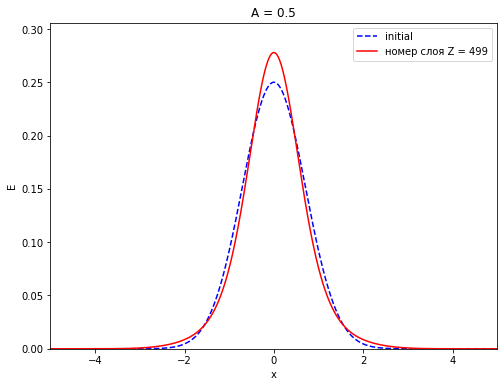

In [9]:
# При А = 0.5 уже есть

E, x = computeE(A=0.5, a=1, LAMBDA=1e-3, E2=2.5e-7, N=1000, L=5, Z=500, dZ=10, i_max=400, eps=1e-6)
I = np.abs(E)**2

anim = plotI(I, x)
HTML(anim)

Ещё одна проверка:

Известно, что фокусное расстояние самофокусировки $f \sim \sqrt{\frac{1}{\frac{|A|^2}{|A_\text{порог}|^2}-1}} \sim \sqrt{\frac{|A_\text{порог}|^2}{|A|^2-|A_\text{порог}|^2}}$

Для $A = 1$ расчитанное расстояние $f_1 \approx 280$, для $A = 0.5$  $f_2 \approx 760$

Тогда 
$\frac{f_2}{f_1} \approx 2.7$

Теоретическое отношение $\frac{f_2}{f_1} = \sqrt{\frac{1^2-0.25^2}{0.5^2-0.25^2}} = 2.23$

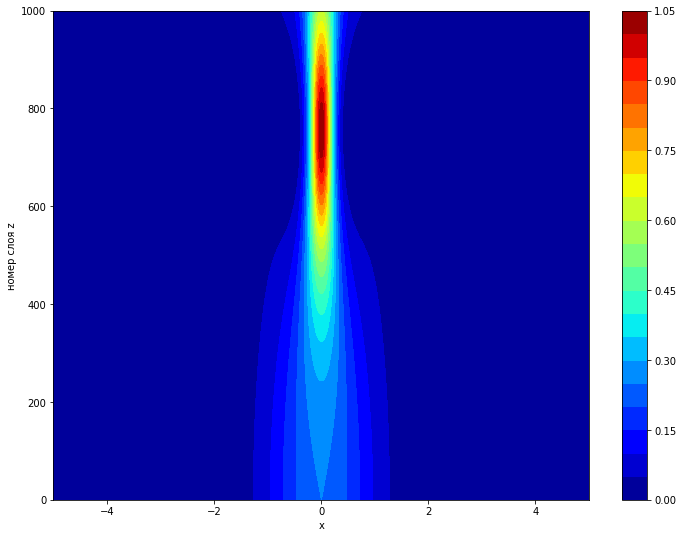

In [10]:
# A = 0.5
E, x = computeE(A=0.5, a=1, LAMBDA=1e-3, E2=1e-6, N=1000, L=5, Z=1000, dZ=5, i_max=400, eps=1e-6)
I = np.abs(E)**2

fig, ax = plt.subplots(figsize = (12,9))
ax.set_xlabel("x")
ax.set_ylabel("номер слоя z")
colorinterpolation = 25
colourMap = plt.cm.jet
picture = ax.contourf(I, colorinterpolation, cmap=colourMap, extent=(-5, 5, 0, 1000))
fig.colorbar(picture)

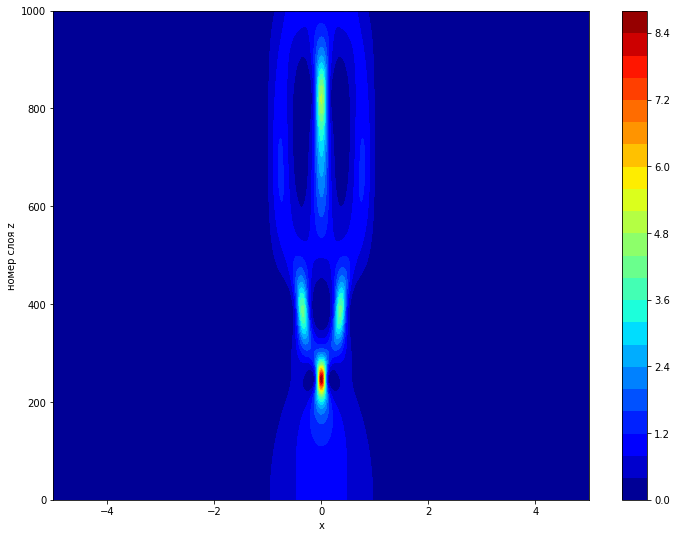

In [11]:
# A = 1
E, x = computeE(A=1, a=1, LAMBDA=1e-3, E2=1e-6, N=1000, L=5, Z=1000, dZ=5, i_max=400, eps=1e-6)
I = np.abs(E)**2

fig, ax = plt.subplots(figsize = (12,9))
ax.set_xlabel("x")
ax.set_ylabel("номер слоя z")
colorinterpolation = 25
colourMap = plt.cm.jet
picture = ax.contourf(I, colorinterpolation, cmap=colourMap, extent=(-5, 5, 0, 1000))
fig.colorbar(picture)